# Обнаружение пожаров по фото и видео

In [1]:
import matplotlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import argparse
import sys

In [2]:
import tensorflow as tf

In [3]:
import cv2

In [4]:
from imutils import paths

In [5]:
import os

In [6]:
from tensorflow.keras.applications import VGG16

## Подготовка данных

In [7]:
FIRE_PATH = "C:/Users/Marinka/Desktop/pract/fire-detection/fire"
NO_FIRE_PATH = "C:/Users/Marinka/Desktop/pract/fire-detection/nofire"

In [8]:
# инициализировать метки классов в наборе данных
CLASSES_NAMES = ["NoFire", "Fire"]

In [9]:
# функция, которая принимает путь к набору данных
def load_dataset(datasetPath):
    # путь к изображениям
    imagePaths = list(paths.list_images(datasetPath))
    data = []

    for imagePath in imagePaths:
        # загрузка изображений и изменение их размеров до 128x128 пикселей, 
        # игнорируя соотношение сторон
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (128, 128))

        # добавить изображение в список data
        data.append(image)

    # array возвращает список data  в формате массива NumPy
    return np.array(data, dtype="float32")

In [10]:
import numpy as np
# загрузка изображений с огнем и без огня
fireData = load_dataset(FIRE_PATH)
noFireData = load_dataset(NO_FIRE_PATH)

# конструирование меток для классов, 1 - пожар, 0 -нет пожара
fireLabels = np.ones((fireData.shape[0],))
noFireLabels = np.zeros((noFireData.shape[0],))

# функция vstack() соединяет массивы по вертикали
data = np.vstack([fireData, noFireData])
# функция hstack() соединяет массивы по горизонтали
labels = np.hstack([fireLabels, noFireLabels])

# масштабировать интенсивность пикселей до диапазона [0, 1]
data /= 255

In [11]:
# преобразование правильных ответов в формат one hot encoding
labels = to_categorical(labels, num_classes=2)

In [12]:
# создание баланса
classTotal= labels.sum(axis=0) # cуммируются значения по оси 0 (по столбцам)
classWeight = classTotal.max() / classTotal

In [13]:
# размер выборки валидации
VAL_SIZE = 0.2

In [14]:
# разделение на выборку для обучения и выборку для валидации
#x_train -изображения, y_train -метки для обозначения класса
(x_train, x_val, y_train, y_val) = train_test_split(data, labels,
    test_size=VAL_SIZE, 
    random_state=42
  )

## Создание нейронной сети на основе VGG16

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
# from keras.applications.inception_v3 import InceptionV3

In [16]:
baseModel = VGG16(weights="imagenet", include_top=False, # не будет загружена та часть сети, которая отвечает за классификацию
    input_shape=(128, 128, 3))

In [18]:
baseModel.trainable = False

In [19]:
print(baseModel.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [20]:
model = Sequential()
# Добавляем в модель сеть VGG16 вместо слоя
model.add(baseModel)
# СLASSIFIER
# Слой преобразования данных из 2D представления в плоское
model.add(Flatten())
# Первый полносвязный слой для классификации
model.add(Dense(512))
model.add(Activation("relu"))
# Пакетная нормализация
model.add(BatchNormalization())
# Слой регуляризации Dropout
model.add(Dropout(0.5))
# Второй полносвязный слой
model.add(Dense(512))
model.add(Activation("relu"))
# Пакетная нормализация
model.add(BatchNormalization())
# Слой регуляризации Dropout
model.add(Dropout(0.5))
# Выходной слой
model.add(Dense(2))
model.add(Activation("softmax"))

In [21]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               2

In [25]:
# дополнительные обучающие данные
datagen = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="reflect")

## LearningRateFinder

In [27]:
# model.compile(loss="binary_crossentropy", 
#               optimizer=SGD(lr=SPEED, momentum=0.9, decay= SPEED / EPOCHS),
#               metrics=["accuracy"])

In [28]:
# from tensorflow.keras.callbacks import LambdaCallback
# from tensorflow.keras import backend as K
# import matplotlib.pyplot as plt
# import numpy as np
# import tempfile

# class LearningRateFinder:
#     def __init__(self, model, stopFactor=4, beta=0.98):
#         self.model = model
#         self.stopFactor = stopFactor
#         self.beta = beta
#         self.lrs = []
#         self.losses = []
#         self.lrMult = 1
#         self.avgLoss = 0
#         self.bestLoss = 1e9
#         self.batchNum = 0
#         self.weightsFile = None

#     def reset(self):
#         self.lrs = []
#         self.losses = []
#         self.lrMult = 1
#         self.avgLoss = 0
#         self.bestLoss = 1e9
#         self.batchNum = 0
#         self.weightsFile = None

#     def is_data_iter(self, data):
#         iterClasses = ["NumpyArrayIterator", "DirectoryIterator",
#              "DataFrameIterator", "Iterator", "Sequence"]

#         return data.__class__.__name__ in iterClasses

#     def on_batch_end(self, batch, logs):
#         lr = K.get_value(self.model.optimizer.lr)
#         self.lrs.append(lr)
#         l = logs["loss"]
#         self.batchNum += 1
#         self.avgLoss = (self.beta * self.avgLoss) + ((1 - self.beta) * l)
#         smooth = self.avgLoss / (1 - (self.beta ** self.batchNum))
#         self.losses.append(smooth)
#         stopLoss = self.stopFactor * self.bestLoss
#         if self.batchNum > 1 and smooth > stopLoss:
#             self.model.stop_training = True
#             return
#         if self.batchNum == 1 or smooth < self.bestLoss:
#             self.bestLoss = smooth

#         lr *= self.lrMult
#         K.set_value(self.model.optimizer.lr, lr)

#     def find(self, trainData, startLR, endLR, epochs=None,
#         stepsPerEpoch=None, batchSize=32, sampleSize=2048,
#         classWeight=None, verbose=1):

#         self.reset()

#         useGen = self.is_data_iter(trainData)

#         if useGen and stepsPerEpoch is None:
#             msg = "Using generator without supplying stepsPerEpoch"
#             raise Exception(msg)

#         elif not useGen:
#             numSamples = len(trainData[0])
#             stepsPerEpoch = np.ceil(numSamples / float(batchSize))

#         if epochs is None:
#             epochs = int(np.ceil(sampleSize / float(stepsPerEpoch)))

#         numBatchUpdates = epochs * stepsPerEpoch

#         self.lrMult = (endLR / startLR) ** (1.0 / numBatchUpdates)

#         self.weightsFile = tempfile.mkstemp()[1]
#         self.model.save_weights(self.weightsFile)

#         origLR = K.get_value(self.model.optimizer.lr)
#         K.set_value(self.model.optimizer.lr, startLR)

#         callback = LambdaCallback(on_batch_end=lambda batch, logs:
#             self.on_batch_end(batch, logs))

#         if useGen:
#             self.model.fit(
#                 trainData,
#                 steps_per_epoch=stepsPerEpoch,
#                 epochs=epochs,
#                 class_weight=classWeight,
#                 verbose=verbose,
#                 callbacks=[callback])

#         else:
#             self.model.fit(
#                 trainData[0], trainData[1],
#                 batch_size=batchSize,
#                 epochs=epochs,
#                 class_weight=classWeight,
#                 callbacks=[callback],
#                 verbose=verbose)

#         self.model.load_weights(self.weightsFile)
#         K.set_value(self.model.optimizer.lr, origLR)

#     def plot_loss(self, skipBegin=10, skipEnd=1, title=""):
#         lrs = self.lrs[skipBegin:-skipEnd]
#         losses = self.losses[skipBegin:-skipEnd]
#         plt.plot(lrs, losses)
#         plt.xscale("log")
#         plt.xlabel("Learning Rate")
#         plt.ylabel("Loss")
#         if title != "":
#             plt.title(title)


In [29]:
# EPOCHS = 50
# #Размер минивыборки,
# BATCH_SIZE = 64  # изменяем веса нейронных сетей после того, как обрабатываем каждые __ объекта, попробовать 128
# # начальная скорость обучения
# SPEED = 0.01 #

In [30]:
# lrf = LearningRateFinder(model)
# lrf.find(
#     datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
#     1e-10, 1e+1,
#     stepsPerEpoch=np.ceil((x_train.shape[0] / float(BATCH_SIZE))),
#     epochs=20,
#     batchSize=BATCH_SIZE,
#     classWeight=classWeight,
#     verbose=1)

  ...
    to  
  ['...']
Train for 52.0 steps
Epoch 1/20
52/52 [==============================] - 439s 8s/step - loss: 1.4116 - accuracy: 0.4889
Epoch 2/20
52/52 [==============================] - 438s 8s/step - loss: 1.4244 - accuracy: 0.4703
Epoch 3/20
52/52 [==============================] - 434s 8s/step - loss: 1.3466 - accuracy: 0.4988
Epoch 4/20
52/52 [==============================] - 436s 8s/step - loss: 1.4471 - accuracy: 0.4712
Epoch 5/20
52/52 [==============================] - 447s 9s/step - loss: 1.4174 - accuracy: 0.4850
Epoch 6/20
52/52 [==============================] - 507s 10s/step - loss: 1.4207 - accuracy: 0.4910
Epoch 7/20
52/52 [==============================] - 482s 9s/step - loss: 1.3715 - accuracy: 0.4823
Epoch 8/20
52/52 [==============================] - 531s 10s/step - loss: 1.3544 - accuracy: 0.4946
Epoch 9/20
52/52 [==============================] - 428s 8s/step - loss: 1.3233 - accuracy: 0.5078
Epoch 10/20
52/52 [==============================] - 436s 8s/

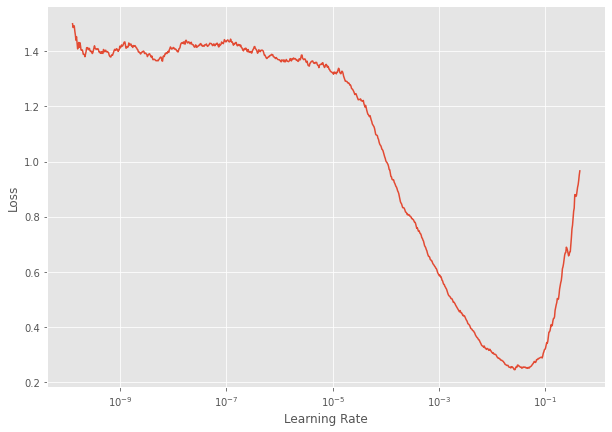

In [31]:
# plt.style.use("ggplot") 
# plt.figure(figsize=(10,7))
# lrf.plot_loss()


## Обучение

In [22]:
EPOCHS = 50
#Размер минивыборки,
BATCH_SIZE = 64  # изменяем веса нейронных сетей после того, как обрабатываем каждые __ объекта, попробовать 128
# начальная скорость обучения
SPEED = 0.01 #

In [23]:
model.compile(loss="binary_crossentropy", 
              optimizer=SGD(lr=SPEED, momentum=0.9, decay= SPEED / EPOCHS),
              metrics=["accuracy"])

In [26]:
# Обучение
model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(x_val, y_val),
    steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=classWeight,
    verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 52 steps, validate on 832 samples
Epoch 1/50
52/52 [==============================] - 524s 10s/step - loss: 0.3715 - accuracy: 0.8741 - val_loss: 3.2286 - val_accuracy: 0.3930
Epoch 2/50
52/52 [==============================] - 521s 10s/step - loss: 0.1816 - accuracy: 0.9369 - val_loss: 0.9071 - val_accuracy: 0.6550
Epoch 3/50
52/52 [==============================] - 520s 10s/step - loss: 0.1548 - accuracy: 0.9432 - val_loss: 0.1241 - val_accuracy: 0.9567
Epoch 4/50
52/52 [==============================] - 520s 10s/step - loss: 0.1626 - accuracy: 0.9384 - val_loss: 0.1507 - val_accuracy: 0.9495
Epoch 5/50
52/52 [==============================] - 521s 10s/step - loss: 0.1504 - accuracy: 0.9513 - val_loss: 0.1171 - val_accuracy: 0.9567
Epoch 6/50
52/52 [==============================] - 520s 10s/step - loss: 0.1361 - accuracy: 0.9510 - val_loss: 0.1163 - val_accuracy: 0.9591
Epo

In [27]:
qual = model.evaluate(x_val, y_val, verbose=0)
print("Точность работы на валидационных данных: %.2f%%" % (qual[1]*100))

Точность работы на валидационных данных: 97.00%


In [28]:
#сохранить модель
model.save("C:/Users/Marinka/Desktop/pract/fire-detection/FireDetection-vgg16-0.h5")

## FineTuning

In [29]:
# разморозка последнего сверточного блока VGG16
baseModel.trainable = True
trainable = False
for layer in baseModel.layers:
    if layer.name == 'block5_conv1':
        trainable = True
    layer.trainable = trainable

In [30]:
# Проверяем количество обучаемых параметров
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               2

In [31]:
model.compile(loss="binary_crossentropy", 
              optimizer=SGD(lr=SPEED, momentum=0.9, decay= SPEED / EPOCHS),
              metrics=["accuracy"])

In [32]:
# Обучение
history = model.fit_generator(
                datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                validation_data=(x_val, y_val),
                steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
                epochs=20,
                class_weight=classWeight,
                verbose=1)

  ...
    to  
  ['...']
Train for 52 steps, validate on 832 samples
Epoch 1/20
52/52 [==============================] - 586s 11s/step - loss: 0.1909 - accuracy: 0.9369 - val_loss: 4.9436 - val_accuracy: 0.3930
Epoch 2/20
52/52 [==============================] - 575s 11s/step - loss: 0.1365 - accuracy: 0.9492 - val_loss: 0.2015 - val_accuracy: 0.9399
Epoch 3/20
52/52 [==============================] - 576s 11s/step - loss: 0.0989 - accuracy: 0.9627 - val_loss: 0.7607 - val_accuracy: 0.7320
Epoch 4/20
52/52 [==============================] - 576s 11s/step - loss: 0.0852 - accuracy: 0.9700 - val_loss: 0.3297 - val_accuracy: 0.9219
Epoch 5/20
52/52 [==============================] - 576s 11s/step - loss: 0.0786 - accuracy: 0.9730 - val_loss: 0.0696 - val_accuracy: 0.9712
Epoch 6/20
52/52 [==============================] - 576s 11s/step - loss: 0.0714 - accuracy: 0.9733 - val_loss: 0.1822 - val_accuracy: 0.9375
Epoch 7/20
52/52 [==============================] - 576s 11s/step - loss: 0.071

In [33]:
qual = model.evaluate(x_val, y_val, verbose=0)
print("Точность работы на валидационных данных: %.2f%%" % (qual[1]*100))

Точность работы на валидационных данных: 98.68%


## Сохранение обученной сети

In [34]:
#сохранить модель
model.save("C:/Users/Marinka/Desktop/pract/fire-detection/FireDetection-vgg16.h5")